In [2]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import Reader, Dataset, SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering, accuracy
from surprise.model_selection import cross_validate, train_test_split, RandomizedSearchCV

In [3]:
# Load in the cleaned data
metaPath = 'Data/cleanedMeta.csv'
reviewPath = 'Data/cleanedReviews.csv'

metaDF = pd.read_csv(metaPath, index_col = 0, keep_default_na = False)
reviewDF = pd.read_csv(reviewPath, index_col = 0, keep_default_na = False)

In [4]:
#check how many products, reviews and reviewers there are
print('There are {} unique products and {} unique reviews made by {} unique reviewers'.format(
    len(metaDF), len(reviewDF), len(reviewDF['reviewerID'].unique())
))

There are 2320 unique products and 84167 unique reviews made by 68482 unique reviewers


In [5]:
# Collect reviewerID, productID and ratings into a single dataframe
ratings = reviewDF[['reviewerID', 'asin', 'overall']]
ratings.head()

,reviewerID,asin,overall
0,AH2IFH762VY5U,B00005N7P0,5.0
1,AOSFI0JEYU4XM,B00005N7P0,5.0
2,A3JPFWKS83R49V,B00005N7OJ,3.0
3,A19FKU6JZQ2ECJ,B00005N7OJ,5.0
4,A25MDGOMZ2GALN,B00005N7P0,5.0


In [6]:
ratings = ratings.rename(columns={'asin': 'productID', 'overall': 'rating'})
ratings.head()

,reviewerID,productID,rating
0,AH2IFH762VY5U,B00005N7P0,5.0
1,AOSFI0JEYU4XM,B00005N7P0,5.0
2,A3JPFWKS83R49V,B00005N7OJ,3.0
3,A19FKU6JZQ2ECJ,B00005N7OJ,5.0
4,A25MDGOMZ2GALN,B00005N7P0,5.0


In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84167 entries, 0 to 89686
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewerID  84167 non-null  object 
 1   productID   84167 non-null  object 
 2   rating      84167 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.6+ MB


In [8]:
# Convert to appropriate types
ratings = ratings.convert_dtypes()
ratings['rating'] = ratings[['rating']].astype('float').astype('int')
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84167 entries, 0 to 89686
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewerID  84167 non-null  string
 1   productID   84167 non-null  string
 2   rating      84167 non-null  int64 
dtypes: int64(1), string(2)
memory usage: 2.6 MB


In [9]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['reviewerID', 'productID', 'rating']], reader)

In [9]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), BaselineOnly(), KNNBasic(), CoClustering(), KNNBaseline()]:
# 
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,fit_time,test_time
Algorithm,,,
KNNBaseline,1.349217,82.513078,1.394721
SVD,1.351326,2.693753,0.123675
BaselineOnly,1.362589,0.127007,0.112341
SVDpp,1.368884,3.757892,0.138685
CoClustering,1.378517,2.906743,0.078901
SlopeOne,1.388397,0.405154,0.129655
KNNBasic,1.397977,83.255367,1.243239
NMF,1.404161,4.925435,0.095663
NormalPredictor,1.803151,0.047581,0.115197


In [10]:
benchmark = []
# Iterate over all algorithms
for algorithm in [KNNWithZScore(), KNNWithMeans()]:

    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,fit_time,test_time
Algorithm,,,
KNNWithMeans,1.381873,83.052358,1.287522
KNNWithZScore,1.383242,84.478136,1.304031


In [11]:
# Use randomizedsearchCV to fine tune the hyperparameters

param_grid = {
    "n_epochs": [5, 10, 15],
    "reg_u": [5, 10, 15],
    "reg_i": [5, 10, 15]
}

rs = RandomizedSearchCV(KNNBaseline, param_grid, measures=["rmse"], refit=True, cv=3)

rs.fit(data)

training_parameters = rs.best_params["rmse"]

print("BEST RMSE: \t", rs.best_score["rmse"])
print("BEST params: \t", training_parameters)


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [10]:
#KNNBaseline had the lowest rmse, I will train and predict with KNNBaseline and use ALS


print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 10,
               'reg_u': 5,
               'reg_i': 10
               }
algo = KNNBaseline(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([1.33787998, 1.3413244 , 1.34028805]),
 'fit_time': (81.53592324256897, 84.45469808578491, 82.99354696273804),
 'test_time': (1.3280231952667236, 1.2650179862976074, 1.2970280647277832)}

In [11]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = KNNBaseline(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3374


1.3374238334741502

In [12]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
#uid: userID
#iid: productID
#rui: true rating of user u for item i
#est: estimated rating of user u for item i
#details: 'actual_k' - number of neighbours
#Iu: set of all items rated by user u
#ui: set of all users that have rated item i
#err: error on the prediction
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [13]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
6621,A21FFUC8BEMDJ7,B00005N7Q5,5.0,5.0,"{'actual_k': 34, 'was_impossible': False}",12,276,0.0
14604,A2DPNAWFCCIZ6Z,B000EGCIW8,5.0,5.0,"{'actual_k': 13, 'was_impossible': False}",5,288,0.0
2917,ALNFHVS3SC4FV,B000W3MB5M,5.0,5.0,"{'actual_k': 2, 'was_impossible': False}",3,321,0.0
2895,A2OI4ZBZ0XBRZI,B0058EONOM,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,45,0.0
2894,A10YB2NJ6X7C9U,B00005N7Q2,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",2,115,0.0
14722,ADS99W8WMEXZ2,B000OPOEEE,5.0,5.0,"{'actual_k': 40, 'was_impossible': False}",7,231,0.0
14754,AXV3OJG9BZ2JW,B00007IJZT,5.0,5.0,"{'actual_k': 25, 'was_impossible': False}",13,234,0.0
2846,A2BJZZUYXWPXY2,B001LF4EVO,5.0,5.0,"{'actual_k': 40, 'was_impossible': False}",2,1005,0.0
2826,A2ZWTFZRNQW7D5,B00005N7T5,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",3,496,0.0
14987,A3LCX3DZP6PT78,B005FSTOJ0,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,24,0.0


The above best predictions have 0 error and are not lucky guesses at all.  Almost all of their Ui's are above 10, with the highest being 816.  This means that a significant number of reviewers have previously rated the target magazine.

In [14]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
8067,AKMEY1BSHSDG7,B00005NIOO,1.0,4.810365,"{'actual_k': 18, 'was_impossible': False}",12,322,3.810365
18330,A1SR70MFML2INX,B00GBJIEQG,1.0,4.824106,"{'actual_k': 2, 'was_impossible': False}",1,18,3.824106
18786,A3AFOX1G1FZ3CC,B00005N7SC,1.0,4.834488,"{'actual_k': 40, 'was_impossible': False}",3,1112,3.834488
9450,A3JUMWF4Y0599R,B002PXW12A,1.0,4.854011,"{'actual_k': 0, 'was_impossible': False}",2,135,3.854011
11956,A1VQCDJJ189ZGP,B001GRZ4CK,1.0,4.859139,"{'actual_k': 1, 'was_impossible': False}",1,14,3.859139
19788,A1SEVKS675Q6MK,B000ILVRWQ,5.0,1.133442,"{'actual_k': 1, 'was_impossible': False}",1,368,3.866558
8623,AO9NOBJYGVBKH,B00007B10Y,1.0,4.870522,"{'actual_k': 7, 'was_impossible': False}",1,1059,3.870522
7708,A173Q6SQGLE1ON,B000IOEJ8W,1.0,4.876820,"{'actual_k': 1, 'was_impossible': False}",2,823,3.876820
455,A3CN7GSFQOQHPJ,B00007BK3L,1.0,4.913477,"{'actual_k': 1, 'was_impossible': False}",1,631,3.913477
14011,A38PH87F2DLJ6S,B00005N7SD,1.0,5.000000,"{'actual_k': 1, 'was_impossible': False}",2,63,4.000000


The worst predictions are pretty off.  Let's take a more in-depth look into the last magazine: "B000IOE9Y6."  The book was rated 1 by the user but the KNNBaseline algorithm predicted a rating of 4.908.

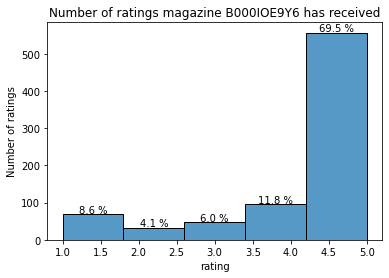

In [15]:
ax = sns.histplot(data = ratings.loc[ratings['productID'] == 'B000IOE9Y6'], x = 'rating', bins = 5)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 3, '{:.1f} %'.format((height / len(ratings.loc[ratings['productID'] == 'B000IOE9Y6']) * 100)),ha="center")
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings magazine B000IOE9Y6 has received')
plt.show();

Further analysis reveals that out of 600 users who rated magazine B000IOE9Y6, 69.5% of users  gave the magazine a rating of 5, followed by 11.8% of users rating the magazine 4.  Less than 25% of users rated the magazine below 4.  This suggests that reviewer A1YPEGJJ2LC8O3 is some kind of outsider.

## Generate recomendations for Reviewer 'A5RHZE7B8SV5Q'

In [16]:
import difflib
import random

def get_magazine_info(productID, metadata):
    
    """
    Returns some basic information about a magazine given the magazine id and the metadata dataframe.
    """
    
    book_info = metaDF[metaDF['asin'] == productID][['asin', 'brand', 
                                                    'title', 'category', 'description']]
    return book_info.to_dict(orient = 'records')

def predict_review(userID, productID, model, metadata):
    
    """
    Predicts the review (on a scale of 1-5) that a user would assign to a specific magazine. 
    """
    
    review_prediction = model.predict(uid=userID, iid=productID)
    return review_prediction.est

def get_user_preference(userID, reviewdata):
    """
    Returns magazines the user has already rated.
    """
    return reviewdata[reviewdata.reviewerID == userID]['asin'].to_list()

def filter_recommendations(recommendations, userPref):
    """
    Remove recommmended magazines that the user has already rated.
    """
    return recommendations[~(recommendations.asin.isin(userPref))]
    
    

def generate_recommendation(userID, model, metadata, reviewDF, thresh=4, max_recs = 5):
    
    """
    Generates magazine recommendations for a user based on a rating threshold. Only
    magazines with a predicted rating at or above the threshold will be recommended.
    """
    
    productIDs = list(metadata['asin'].values)
    random.shuffle(productIDs)
    
    recs = []
    for productID in productIDs:
        rating = predict_review(userID, productID, model, metadata)
        if rating >= thresh:
            mag_info = get_magazine_info(productID, metadata)[0]
            mag_info['est_rating'] = rating
            recs.append(mag_info)
    recDF = pd.DataFrame(recs).sort_values('est_rating', ascending = False)
    filter_recommendations(recDF, get_user_preference(userID, reviewDF))
    return recDF[:max_recs]


In [17]:
pd.set_option('display.max_colwidth', None)
generate_recommendation('A5RHZE7B8SV5Q', algo, metaDF, reviewDF, thresh=4, max_recs = 5)

,asin,brand,title,category,description,est_rating
602,B015HNWWRS,Reader's Digest Association,,"['Literary, Sci-Fi & Mystery', 'Literary Magazines & Journals']","['Discover thousands of tips in health, family, home, money and more for living a richer, more satisfying life. Its everything you need, in one easy read!', '<a href=""/gp/help/customer/display.html/ref=hp_left_ac?ie=UTF8&nodeId=201293140"" target=""_blank"">Learn more</a> about auto-renewal subscriptions on Amazon.com']",5.0
593,B000EWAWPC,Future Publishing Ltd,,,"[""Retro Gamers' aim is to provide its readership with highly interesting, passionately written subject matter that covers all aspects of the retro gaming scene. From the Commodore64 releases to loving tributes to software houses and games of old, readers will that Retro Gamer has it all.""]",5.0
555,B00005N7OC,String Letter Publishers,,"['Arts, Music & Photography', 'Music']","['Written by and for musicians. Covers a variety of musical styles and includes transcriptions from recordings and solo pieces for guitar.', '', '']",5.0
274,B000225WAY,New York Times,,"['Travel, City & Regional', 'United States', 'Northeast']","['New York Times newspaper for your national and international journalism, on of Americas most popular sources of news around the world.', '', '']",5.0
76,B0160CN1YI,Cricket Media,,['Parenting & Families'],"['Faces helps kids ages 9 to above (grades 4 and up) understand how people in other countries and cultures live. Each issue focuses on a different culture - from Jordan to the emerging Asian states - including stories about daily life, folk tales, and history and traditions of the people and places.', '<a href=""/gp/help/customer/display.html/ref=hp_left_ac?ie=UTF8&nodeId=201293140"" target=""_blank"">Learn more</a> about auto-renewal subscriptions on Amazon.com']",5.0
